In [1]:
import os
import sys
import matplotlib.pyplot as plt
import xml.etree.ElementTree as Et
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import shutil

from xml.etree.ElementTree import Element, ElementTree
from PIL import Image
from PIL import ImageDraw
from torchvision.models import resnet152
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
#reproducibility
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
img_path = "./JPEGImages"
ann_path = "./Annotations"
_, _, idx2file = next(os.walk(ann_path))

In [5]:
_classes = []
_idx2size = []
_idx2map = []

print("Now start parsing xml files")

for i, file in enumerate(idx2file):
    
    xml = open(os.path.join(ann_path, file), "r")
    tree = Et.parse(xml)
    root = tree.getroot()
    
    img_size = root.find("size")
    width = img_size.find("width").text
    height = img_size.find("height").text
    channels = img_size.find("depth").text
    
    size=[int(width), int(height), int(channels)]
    _idx2size.append(size)
    
    print("image {}, image size: {}".format(i, _idx2size[i]))
    
    objects= root.findall("object")
    
    _map = {}
    for j, obj in enumerate(objects):
        _class = obj.find("name").text
        
        if _class not in _classes:
            _classes.append(_class)
        
        box = obj.find("bndbox")
        xmin = box.find("xmin").text
        ymin = box.find("ymin").text
        xmax = box.find("xmax").text
        ymax = box.find("ymax").text
        
        box_loc = [int(float(xmin)), int(float(ymin)), int(float(xmax)), int(float(ymax))]
        _map[_class] = box_loc
        
    _idx2map.append(_map)
    
    for key, box in _idx2map[i].items():
        print("    class : {}, box_size: {}".format(key, box))

Now start parsing xml files
image 0, image size: [486, 500, 3]
    class : person, box_size: [174, 101, 349, 351]
image 1, image size: [500, 281, 3]
    class : aeroplane, box_size: [133, 88, 197, 123]
    class : person, box_size: [26, 189, 44, 238]
image 2, image size: [500, 366, 3]
    class : aeroplane, box_size: [325, 188, 411, 223]
image 3, image size: [500, 375, 3]
    class : tvmonitor, box_size: [156, 89, 344, 279]
image 4, image size: [500, 335, 3]
    class : train, box_size: [1, 36, 235, 299]
image 5, image size: [500, 333, 3]
    class : boat, box_size: [184, 214, 281, 252]
image 6, image size: [500, 375, 3]
    class : dog, box_size: [123, 115, 379, 275]
    class : chair, box_size: [75, 1, 428, 375]
image 7, image size: [500, 375, 3]
    class : bird, box_size: [27, 45, 266, 375]
image 8, image size: [500, 375, 3]
    class : tvmonitor, box_size: [22, 28, 251, 273]
image 9, image size: [500, 375, 3]
    class : train, box_size: [1, 26, 358, 340]
image 10, image size: [33

image 292, image size: [500, 332, 3]
    class : tvmonitor, box_size: [243, 129, 304, 181]
    class : chair, box_size: [265, 278, 374, 332]
    class : sofa, box_size: [1, 199, 99, 332]
    class : diningtable, box_size: [234, 204, 500, 332]
    class : dog, box_size: [210, 194, 257, 234]
image 293, image size: [500, 333, 3]
    class : dog, box_size: [171, 57, 344, 280]
image 294, image size: [500, 375, 3]
    class : tvmonitor, box_size: [1, 115, 201, 326]
image 295, image size: [500, 375, 3]
    class : tvmonitor, box_size: [144, 187, 246, 287]
    class : bottle, box_size: [290, 68, 305, 107]
    class : chair, box_size: [216, 289, 380, 375]
image 296, image size: [500, 334, 3]
    class : person, box_size: [246, 21, 485, 334]
image 297, image size: [500, 357, 3]
    class : person, box_size: [314, 24, 483, 357]
image 298, image size: [500, 375, 3]
    class : boat, box_size: [129, 81, 369, 325]
image 299, image size: [500, 375, 3]
    class : person, box_size: [253, 139, 402, 276

image 610, image size: [500, 375, 3]
    class : sofa, box_size: [38, 188, 304, 360]
image 611, image size: [500, 374, 3]
    class : bottle, box_size: [199, 247, 242, 367]
    class : tvmonitor, box_size: [314, 114, 499, 329]
    class : person, box_size: [143, 145, 266, 336]
image 612, image size: [375, 500, 3]
    class : person, box_size: [78, 182, 282, 500]
image 613, image size: [500, 375, 3]
    class : person, box_size: [100, 273, 139, 361]
image 614, image size: [500, 375, 3]
    class : person, box_size: [96, 98, 208, 160]
    class : boat, box_size: [1, 1, 112, 62]
image 615, image size: [333, 500, 3]
    class : dog, box_size: [49, 98, 276, 422]
image 616, image size: [480, 423, 3]
    class : person, box_size: [176, 52, 278, 224]
    class : horse, box_size: [34, 73, 358, 417]
image 617, image size: [500, 375, 3]
    class : dog, box_size: [94, 71, 457, 255]
    class : sofa, box_size: [3, 2, 499, 374]
image 618, image size: [480, 367, 3]
    class : person, box_size: [161

image 939, image size: [500, 307, 3]
    class : train, box_size: [1, 1, 500, 303]
image 940, image size: [500, 333, 3]
    class : person, box_size: [237, 144, 362, 285]
image 941, image size: [500, 333, 3]
    class : motorbike, box_size: [15, 182, 228, 333]
image 942, image size: [500, 375, 3]
    class : person, box_size: [26, 269, 154, 375]
image 943, image size: [333, 500, 3]
    class : person, box_size: [35, 208, 333, 500]
    class : chair, box_size: [70, 432, 134, 500]
image 944, image size: [332, 500, 3]
    class : person, box_size: [1, 97, 282, 500]
image 945, image size: [500, 375, 3]
    class : person, box_size: [1, 133, 90, 375]
    class : tvmonitor, box_size: [8, 66, 106, 146]
image 946, image size: [500, 375, 3]
    class : pottedplant, box_size: [338, 107, 433, 302]
image 947, image size: [375, 500, 3]
    class : person, box_size: [282, 179, 334, 388]
image 948, image size: [500, 333, 3]
    class : person, box_size: [1, 112, 25, 156]
    class : motorbike, box_si

image 1275, image size: [500, 375, 3]
    class : person, box_size: [148, 145, 473, 375]
image 1276, image size: [500, 375, 3]
    class : person, box_size: [96, 41, 354, 373]
image 1277, image size: [500, 333, 3]
    class : aeroplane, box_size: [424, 152, 500, 186]
    class : person, box_size: [237, 108, 272, 154]
image 1278, image size: [500, 375, 3]
    class : person, box_size: [180, 50, 453, 375]
image 1279, image size: [500, 440, 3]
    class : boat, box_size: [124, 59, 232, 206]
image 1280, image size: [333, 500, 3]
    class : person, box_size: [202, 198, 333, 500]
image 1281, image size: [500, 333, 3]
    class : person, box_size: [191, 80, 280, 212]
    class : bottle, box_size: [13, 163, 64, 258]
image 1282, image size: [500, 375, 3]
    class : cow, box_size: [464, 75, 500, 132]
    class : car, box_size: [440, 69, 485, 83]
image 1283, image size: [500, 375, 3]
    class : person, box_size: [437, 137, 500, 375]
image 1284, image size: [500, 375, 3]
    class : person, box

image 1607, image size: [500, 357, 3]
    class : person, box_size: [272, 133, 324, 178]
image 1608, image size: [500, 375, 3]
    class : diningtable, box_size: [139, 226, 311, 351]
    class : chair, box_size: [234, 227, 310, 276]
image 1609, image size: [333, 500, 3]
    class : person, box_size: [34, 331, 231, 500]
image 1610, image size: [500, 370, 3]
    class : motorbike, box_size: [212, 180, 267, 228]
    class : person, box_size: [189, 169, 250, 225]
image 1611, image size: [500, 344, 3]
    class : horse, box_size: [71, 94, 229, 279]
    class : person, box_size: [144, 71, 188, 205]
image 1612, image size: [500, 375, 3]
    class : person, box_size: [183, 109, 332, 375]
image 1613, image size: [500, 375, 3]
    class : person, box_size: [256, 156, 353, 375]
image 1614, image size: [500, 402, 3]
    class : person, box_size: [256, 31, 491, 402]
image 1615, image size: [348, 500, 3]
    class : person, box_size: [34, 29, 310, 498]
image 1616, image size: [500, 333, 3]
    class

image 1937, image size: [500, 375, 3]
    class : person, box_size: [177, 161, 337, 375]
    class : chair, box_size: [40, 232, 147, 375]
    class : diningtable, box_size: [208, 271, 479, 375]
    class : bicycle, box_size: [368, 224, 500, 366]
image 1938, image size: [500, 376, 3]
    class : bird, box_size: [1, 9, 460, 373]
image 1939, image size: [500, 396, 3]
    class : dog, box_size: [202, 151, 309, 224]
image 1940, image size: [500, 400, 3]
    class : bird, box_size: [153, 251, 285, 311]
image 1941, image size: [500, 375, 3]
    class : car, box_size: [241, 218, 282, 255]
    class : motorbike, box_size: [455, 219, 500, 258]
image 1942, image size: [500, 375, 3]
    class : person, box_size: [94, 65, 272, 359]
    class : chair, box_size: [1, 119, 282, 375]
image 1943, image size: [500, 333, 3]
    class : person, box_size: [52, 58, 123, 137]
    class : diningtable, box_size: [1, 124, 94, 158]
image 1944, image size: [500, 385, 3]
    class : person, box_size: [205, 72, 292, 

image 2277, image size: [500, 318, 3]
    class : person, box_size: [129, 123, 287, 249]
    class : bicycle, box_size: [253, 1, 478, 203]
image 2278, image size: [500, 375, 3]
    class : person, box_size: [311, 63, 481, 375]
    class : bottle, box_size: [385, 8, 413, 54]
image 2279, image size: [500, 375, 3]
    class : person, box_size: [118, 162, 137, 175]
    class : bottle, box_size: [178, 151, 203, 233]
image 2280, image size: [500, 326, 3]
    class : person, box_size: [224, 152, 294, 249]
    class : boat, box_size: [83, 222, 227, 298]
image 2281, image size: [500, 375, 3]
    class : car, box_size: [378, 239, 439, 295]
    class : person, box_size: [298, 238, 316, 281]
image 2282, image size: [500, 375, 3]
    class : train, box_size: [23, 80, 490, 303]
image 2283, image size: [500, 334, 3]
    class : bird, box_size: [157, 84, 379, 240]
image 2284, image size: [500, 375, 3]
    class : cat, box_size: [1, 1, 398, 375]
image 2285, image size: [357, 500, 3]
    class : person,

image 2596, image size: [500, 230, 3]
    class : aeroplane, box_size: [46, 54, 455, 201]
image 2597, image size: [500, 375, 3]
    class : person, box_size: [280, 80, 392, 336]
    class : pottedplant, box_size: [99, 30, 124, 99]
image 2598, image size: [375, 500, 3]
    class : sofa, box_size: [1, 277, 375, 500]
    class : person, box_size: [52, 110, 356, 500]
image 2599, image size: [500, 373, 3]
    class : train, box_size: [44, 151, 110, 192]
image 2600, image size: [500, 375, 3]
    class : aeroplane, box_size: [93, 137, 472, 298]
    class : person, box_size: [224, 178, 242, 198]
image 2601, image size: [500, 375, 3]
    class : aeroplane, box_size: [1, 68, 500, 375]
image 2602, image size: [500, 334, 3]
    class : person, box_size: [82, 70, 388, 334]
image 2603, image size: [500, 375, 3]
    class : dog, box_size: [118, 24, 398, 375]
image 2604, image size: [500, 309, 3]
    class : person, box_size: [135, 148, 164, 231]
image 2605, image size: [500, 389, 3]
    class : perso

image 2921, image size: [500, 375, 3]
    class : bird, box_size: [168, 149, 282, 241]
image 2922, image size: [500, 375, 3]
    class : car, box_size: [148, 263, 157, 272]
    class : person, box_size: [285, 259, 290, 280]
image 2923, image size: [500, 375, 3]
    class : person, box_size: [348, 184, 500, 375]
    class : diningtable, box_size: [1, 272, 500, 375]
    class : bottle, box_size: [25, 329, 49, 375]
image 2924, image size: [375, 500, 3]
    class : person, box_size: [178, 1, 230, 45]
image 2925, image size: [500, 375, 3]
    class : cow, box_size: [57, 2, 435, 375]
image 2926, image size: [375, 500, 3]
    class : horse, box_size: [50, 47, 290, 500]
image 2927, image size: [249, 363, 3]
    class : sofa, box_size: [1, 139, 249, 328]
    class : person, box_size: [9, 222, 121, 363]
image 2928, image size: [500, 333, 3]
    class : motorbike, box_size: [260, 154, 328, 266]
    class : person, box_size: [238, 114, 316, 232]
image 2929, image size: [500, 375, 3]
    class : do

image 3234, image size: [500, 333, 3]
    class : bicycle, box_size: [27, 144, 216, 330]
image 3235, image size: [375, 500, 3]
    class : dog, box_size: [131, 192, 291, 300]
image 3236, image size: [500, 333, 3]
    class : motorbike, box_size: [61, 150, 170, 279]
    class : person, box_size: [58, 56, 295, 261]
image 3237, image size: [500, 404, 3]
    class : pottedplant, box_size: [208, 161, 235, 186]
    class : person, box_size: [295, 144, 328, 202]
image 3238, image size: [500, 375, 3]
    class : cat, box_size: [1, 1, 457, 375]
image 3239, image size: [497, 500, 3]
    class : tvmonitor, box_size: [114, 153, 323, 328]
image 3240, image size: [500, 375, 3]
    class : tvmonitor, box_size: [1, 96, 29, 232]
    class : pottedplant, box_size: [107, 1, 246, 95]
image 3241, image size: [500, 375, 3]
    class : cow, box_size: [36, 61, 354, 375]
image 3242, image size: [500, 333, 3]
    class : cat, box_size: [108, 73, 377, 266]
image 3243, image size: [367, 500, 3]
    class : dog, b

image 3541, image size: [500, 375, 3]
    class : tvmonitor, box_size: [40, 185, 142, 279]
    class : person, box_size: [139, 110, 226, 375]
image 3542, image size: [500, 333, 3]
    class : bird, box_size: [382, 220, 446, 299]
image 3543, image size: [500, 375, 3]
    class : sofa, box_size: [1, 1, 271, 204]
    class : pottedplant, box_size: [211, 1, 287, 43]
image 3544, image size: [500, 333, 3]
    class : boat, box_size: [32, 1, 199, 257]
image 3545, image size: [500, 333, 3]
    class : aeroplane, box_size: [79, 130, 317, 198]
image 3546, image size: [500, 341, 3]
    class : sheep, box_size: [131, 77, 473, 296]
image 3547, image size: [500, 333, 3]
    class : aeroplane, box_size: [6, 68, 493, 212]
image 3548, image size: [500, 375, 3]
    class : sheep, box_size: [247, 112, 353, 183]
    class : person, box_size: [183, 69, 247, 261]
image 3549, image size: [400, 300, 3]
    class : cat, box_size: [47, 27, 309, 257]
image 3550, image size: [500, 375, 3]
    class : motorbike, b

image 3859, image size: [374, 500, 3]
    class : bicycle, box_size: [170, 9, 245, 159]
    class : person, box_size: [296, 110, 336, 231]
    class : car, box_size: [26, 164, 358, 416]
image 3860, image size: [500, 375, 3]
    class : sofa, box_size: [1, 70, 500, 375]
    class : person, box_size: [87, 98, 292, 375]
image 3861, image size: [430, 500, 3]
    class : bicycle, box_size: [166, 207, 290, 443]
    class : person, box_size: [34, 24, 99, 151]
    class : car, box_size: [321, 81, 420, 264]
image 3862, image size: [500, 375, 3]
    class : chair, box_size: [106, 16, 441, 375]
image 3863, image size: [375, 500, 3]
    class : pottedplant, box_size: [1, 51, 366, 474]
image 3864, image size: [500, 375, 3]
    class : aeroplane, box_size: [1, 35, 487, 293]
    class : person, box_size: [375, 235, 381, 248]
image 3865, image size: [500, 375, 3]
    class : person, box_size: [160, 131, 262, 312]
    class : tvmonitor, box_size: [45, 148, 142, 225]
image 3866, image size: [500, 333, 3

image 4147, image size: [500, 333, 3]
    class : cat, box_size: [155, 26, 500, 324]
    class : sofa, box_size: [1, 1, 500, 333]
image 4148, image size: [500, 375, 3]
    class : dog, box_size: [200, 153, 289, 282]
    class : person, box_size: [146, 38, 335, 375]
    class : car, box_size: [415, 185, 449, 206]
image 4149, image size: [375, 500, 3]
    class : person, box_size: [40, 129, 185, 425]
    class : chair, box_size: [1, 264, 170, 500]
image 4150, image size: [500, 375, 3]
    class : train, box_size: [1, 1, 103, 375]
image 4151, image size: [375, 500, 3]
    class : person, box_size: [124, 185, 142, 217]
    class : bicycle, box_size: [218, 248, 303, 372]
image 4152, image size: [333, 500, 3]
    class : motorbike, box_size: [139, 116, 304, 414]
    class : person, box_size: [20, 128, 197, 369]
image 4153, image size: [500, 375, 3]
    class : chair, box_size: [1, 99, 276, 375]
    class : person, box_size: [213, 1, 487, 375]
    class : cat, box_size: [178, 127, 301, 298]
i

image 4435, image size: [324, 432, 3]
    class : dog, box_size: [74, 250, 206, 346]
image 4436, image size: [500, 338, 3]
    class : bird, box_size: [240, 1, 500, 157]
image 4437, image size: [500, 375, 3]
    class : chair, box_size: [29, 311, 113, 375]
    class : person, box_size: [253, 126, 330, 219]
image 4438, image size: [500, 375, 3]
    class : chair, box_size: [1, 227, 90, 375]
    class : diningtable, box_size: [36, 228, 387, 375]
    class : bottle, box_size: [35, 72, 46, 103]
image 4439, image size: [500, 375, 3]
    class : boat, box_size: [15, 122, 484, 248]
image 4440, image size: [500, 333, 3]
    class : aeroplane, box_size: [265, 165, 373, 200]
    class : person, box_size: [312, 146, 324, 169]
image 4441, image size: [500, 375, 3]
    class : motorbike, box_size: [61, 206, 119, 316]
    class : person, box_size: [204, 170, 237, 261]
image 4442, image size: [500, 375, 3]
    class : horse, box_size: [1, 1, 166, 320]
image 4443, image size: [500, 375, 3]
    class :

image 4673, image size: [500, 375, 3]
    class : sheep, box_size: [1, 1, 500, 375]
image 4674, image size: [500, 375, 3]
    class : boat, box_size: [218, 174, 258, 193]
image 4675, image size: [500, 375, 3]
    class : cat, box_size: [55, 138, 222, 232]
    class : person, box_size: [160, 49, 196, 118]
image 4676, image size: [500, 375, 3]
    class : cat, box_size: [143, 39, 500, 295]
image 4677, image size: [500, 355, 3]
    class : bicycle, box_size: [51, 41, 468, 332]
image 4678, image size: [500, 375, 3]
    class : tvmonitor, box_size: [264, 173, 424, 305]
image 4679, image size: [500, 332, 3]
    class : dog, box_size: [309, 107, 402, 206]
    class : person, box_size: [96, 21, 253, 332]
image 4680, image size: [500, 375, 3]
    class : car, box_size: [434, 228, 473, 247]
    class : person, box_size: [379, 228, 396, 273]
    class : pottedplant, box_size: [388, 187, 398, 196]
image 4681, image size: [500, 375, 3]
    class : chair, box_size: [251, 160, 302, 214]
    class : d

image 4875, image size: [500, 370, 3]
    class : train, box_size: [150, 151, 357, 233]
image 4876, image size: [500, 333, 3]
    class : sheep, box_size: [271, 151, 306, 186]
    class : car, box_size: [391, 228, 500, 333]
image 4877, image size: [500, 375, 3]
    class : sheep, box_size: [187, 70, 323, 169]
image 4878, image size: [375, 500, 3]
    class : motorbike, box_size: [105, 193, 243, 447]
image 4879, image size: [333, 500, 3]
    class : bicycle, box_size: [266, 238, 333, 322]
    class : person, box_size: [266, 197, 333, 308]
image 4880, image size: [375, 500, 3]
    class : bottle, box_size: [234, 296, 289, 395]
    class : diningtable, box_size: [217, 129, 356, 229]
    class : chair, box_size: [316, 152, 372, 222]
    class : pottedplant, box_size: [160, 27, 249, 218]
image 4881, image size: [500, 375, 3]
    class : pottedplant, box_size: [336, 1, 476, 224]
image 4882, image size: [377, 500, 3]
    class : person, box_size: [6, 62, 377, 474]
    class : diningtable, box

image 5131, image size: [375, 500, 3]
    class : person, box_size: [1, 91, 375, 500]
image 5132, image size: [375, 500, 3]
    class : cow, box_size: [1, 158, 90, 265]
image 5133, image size: [500, 334, 3]
    class : person, box_size: [406, 183, 453, 307]
image 5134, image size: [384, 500, 3]
    class : horse, box_size: [46, 62, 310, 423]
image 5135, image size: [375, 500, 3]
    class : person, box_size: [212, 48, 356, 391]
image 5136, image size: [333, 500, 3]
    class : train, box_size: [97, 141, 333, 387]
image 5137, image size: [500, 333, 3]
    class : motorbike, box_size: [73, 21, 397, 320]
    class : person, box_size: [143, 25, 334, 224]
image 5138, image size: [500, 333, 3]
    class : car, box_size: [95, 117, 404, 225]
    class : person, box_size: [5, 1, 41, 50]
image 5139, image size: [500, 375, 3]
    class : cat, box_size: [96, 38, 328, 297]
image 5140, image size: [500, 336, 3]
    class : chair, box_size: [27, 73, 165, 316]
image 5141, image size: [500, 334, 3]
   

    class : aeroplane, box_size: [1, 181, 500, 377]
    class : person, box_size: [250, 324, 297, 377]
image 5436, image size: [360, 240, 3]
    class : aeroplane, box_size: [74, 67, 213, 132]
image 5437, image size: [500, 333, 3]
    class : train, box_size: [1, 146, 36, 209]
image 5438, image size: [389, 500, 3]
    class : bird, box_size: [32, 147, 183, 492]
image 5439, image size: [333, 500, 3]
    class : sheep, box_size: [82, 283, 175, 422]
image 5440, image size: [500, 375, 3]
    class : sofa, box_size: [12, 135, 495, 321]
    class : chair, box_size: [337, 316, 487, 375]
image 5441, image size: [331, 500, 3]
    class : sofa, box_size: [1, 102, 331, 500]
    class : person, box_size: [38, 63, 331, 500]
image 5442, image size: [500, 375, 3]
    class : sheep, box_size: [358, 89, 490, 345]
image 5443, image size: [500, 333, 3]
    class : motorbike, box_size: [13, 1, 345, 128]
    class : person, box_size: [414, 1, 500, 133]
image 5444, image size: [500, 333, 3]
    class : bird

image 5726, image size: [333, 500, 3]
    class : car, box_size: [1, 91, 333, 500]
image 5727, image size: [500, 334, 3]
    class : diningtable, box_size: [2, 82, 500, 334]
    class : chair, box_size: [382, 264, 500, 334]
image 5728, image size: [500, 375, 3]
    class : bird, box_size: [415, 1, 500, 149]
image 5729, image size: [500, 375, 3]
    class : bottle, box_size: [160, 216, 393, 282]
    class : dog, box_size: [78, 20, 242, 263]
image 5730, image size: [500, 375, 3]
    class : dog, box_size: [145, 74, 366, 284]
image 5731, image size: [500, 333, 3]
    class : cat, box_size: [1, 163, 386, 333]
image 5732, image size: [500, 375, 3]
    class : pottedplant, box_size: [310, 85, 416, 339]
image 5733, image size: [500, 375, 3]
    class : person, box_size: [361, 124, 371, 133]
    class : boat, box_size: [341, 116, 400, 147]
image 5734, image size: [333, 500, 3]
    class : sheep, box_size: [282, 94, 333, 391]
image 5735, image size: [500, 357, 3]
    class : car, box_size: [419

    class : aeroplane, box_size: [14, 88, 488, 311]
image 6018, image size: [500, 375, 3]
    class : car, box_size: [19, 80, 448, 275]
image 6019, image size: [500, 333, 3]
    class : sheep, box_size: [152, 49, 449, 292]
image 6020, image size: [375, 500, 3]
    class : chair, box_size: [20, 1, 375, 500]
image 6021, image size: [334, 500, 3]
    class : dog, box_size: [3, 62, 334, 500]
image 6022, image size: [500, 375, 3]
    class : boat, box_size: [368, 120, 483, 360]
    class : person, box_size: [363, 168, 395, 212]
image 6023, image size: [500, 375, 3]
    class : cow, box_size: [113, 122, 343, 277]
image 6024, image size: [500, 375, 3]
    class : person, box_size: [17, 111, 143, 266]
    class : bottle, box_size: [1, 193, 29, 324]
image 6025, image size: [500, 333, 3]
    class : diningtable, box_size: [1, 1, 500, 333]
    class : chair, box_size: [17, 1, 130, 95]
image 6026, image size: [500, 375, 3]
    class : person, box_size: [4, 98, 25, 162]
    class : bird, box_size: 

image 6297, image size: [500, 375, 3]
    class : tvmonitor, box_size: [341, 160, 380, 195]
    class : chair, box_size: [439, 192, 493, 277]
    class : person, box_size: [57, 150, 86, 224]
image 6298, image size: [500, 333, 3]
    class : dog, box_size: [1, 52, 343, 333]
    class : person, box_size: [82, 1, 500, 333]
image 6299, image size: [333, 500, 3]
    class : motorbike, box_size: [26, 179, 308, 466]
image 6300, image size: [500, 334, 3]
    class : person, box_size: [430, 95, 500, 280]
    class : bicycle, box_size: [194, 258, 493, 334]
image 6301, image size: [500, 375, 3]
    class : horse, box_size: [1, 1, 362, 375]
image 6302, image size: [500, 375, 3]
    class : car, box_size: [1, 110, 367, 315]
    class : boat, box_size: [332, 125, 480, 204]
    class : person, box_size: [3, 115, 18, 166]
image 6303, image size: [500, 375, 3]
    class : person, box_size: [161, 14, 394, 375]
    class : sofa, box_size: [141, 1, 490, 173]
    class : chair, box_size: [373, 112, 500, 37

image 6600, image size: [500, 375, 3]
    class : sheep, box_size: [205, 121, 481, 359]
image 6601, image size: [500, 334, 3]
    class : dog, box_size: [90, 94, 380, 314]
    class : person, box_size: [66, 1, 187, 120]
image 6602, image size: [500, 375, 3]
    class : bicycle, box_size: [45, 85, 441, 350]
    class : pottedplant, box_size: [357, 70, 431, 142]
image 6603, image size: [500, 375, 3]
    class : person, box_size: [273, 88, 367, 355]
    class : tvmonitor, box_size: [35, 196, 104, 267]
    class : chair, box_size: [241, 221, 290, 327]
image 6604, image size: [500, 375, 3]
    class : bus, box_size: [31, 197, 58, 221]
    class : car, box_size: [1, 221, 67, 291]
image 6605, image size: [356, 500, 3]
    class : pottedplant, box_size: [1, 109, 307, 495]
image 6606, image size: [500, 375, 3]
    class : cat, box_size: [188, 72, 319, 341]
image 6607, image size: [500, 335, 3]
    class : bird, box_size: [179, 132, 262, 186]
image 6608, image size: [500, 375, 3]
    class : tra

    class : cow, box_size: [189, 36, 500, 333]
image 6923, image size: [500, 346, 3]
    class : train, box_size: [12, 125, 480, 247]
image 6924, image size: [334, 500, 3]
    class : chair, box_size: [78, 130, 258, 440]
image 6925, image size: [500, 375, 3]
    class : diningtable, box_size: [126, 198, 500, 375]
    class : chair, box_size: [425, 185, 500, 230]
    class : sofa, box_size: [432, 164, 500, 198]
image 6926, image size: [500, 333, 3]
    class : aeroplane, box_size: [473, 173, 500, 214]
image 6927, image size: [500, 284, 3]
    class : car, box_size: [45, 50, 469, 238]
image 6928, image size: [500, 500, 3]
    class : tvmonitor, box_size: [1, 1, 166, 500]
image 6929, image size: [500, 333, 3]
    class : tvmonitor, box_size: [134, 122, 216, 202]
    class : chair, box_size: [386, 166, 470, 253]
image 6930, image size: [500, 338, 3]
    class : bus, box_size: [82, 38, 301, 279]
image 6931, image size: [500, 375, 3]
    class : car, box_size: [264, 150, 305, 178]
    class 

image 7244, image size: [500, 294, 3]
    class : person, box_size: [77, 142, 92, 166]
    class : motorbike, box_size: [128, 162, 149, 177]
    class : car, box_size: [250, 157, 330, 208]
image 7245, image size: [500, 340, 3]
    class : cat, box_size: [322, 59, 500, 340]
    class : tvmonitor, box_size: [1, 1, 416, 340]
image 7246, image size: [500, 375, 3]
    class : sofa, box_size: [168, 166, 249, 230]
    class : diningtable, box_size: [170, 228, 500, 375]
image 7247, image size: [333, 500, 3]
    class : boat, box_size: [78, 224, 333, 332]
image 7248, image size: [500, 357, 3]
    class : dog, box_size: [293, 92, 356, 142]
    class : person, box_size: [226, 41, 262, 75]
    class : chair, box_size: [382, 71, 454, 161]
    class : car, box_size: [125, 22, 150, 52]
image 7249, image size: [500, 500, 3]
    class : sofa, box_size: [387, 375, 500, 500]
    class : chair, box_size: [1, 277, 115, 412]
image 7250, image size: [500, 375, 3]
    class : sheep, box_size: [36, 1, 355, 213

image 7551, image size: [500, 375, 3]
    class : cow, box_size: [1, 1, 460, 375]
image 7552, image size: [500, 375, 3]
    class : bus, box_size: [1, 75, 88, 313]
image 7553, image size: [485, 500, 3]
    class : horse, box_size: [128, 16, 426, 500]
image 7554, image size: [500, 374, 3]
    class : diningtable, box_size: [11, 258, 359, 374]
    class : pottedplant, box_size: [325, 1, 440, 137]
    class : person, box_size: [12, 99, 153, 267]
    class : bottle, box_size: [188, 285, 237, 374]
image 7555, image size: [500, 375, 3]
    class : cat, box_size: [1, 28, 409, 358]
image 7556, image size: [500, 375, 3]
    class : bicycle, box_size: [50, 15, 473, 369]
image 7557, image size: [500, 375, 3]
    class : person, box_size: [1, 6, 95, 375]
    class : car, box_size: [62, 34, 500, 362]
image 7558, image size: [500, 333, 3]
    class : train, box_size: [1, 117, 319, 333]
image 7559, image size: [500, 334, 3]
    class : motorbike, box_size: [277, 145, 361, 220]
    class : person, box

image 7838, image size: [375, 500, 3]
    class : bottle, box_size: [138, 51, 374, 483]
image 7839, image size: [500, 375, 3]
    class : sheep, box_size: [115, 177, 226, 210]
    class : person, box_size: [197, 59, 324, 220]
image 7840, image size: [500, 375, 3]
    class : tvmonitor, box_size: [61, 57, 498, 320]
image 7841, image size: [500, 360, 3]
    class : cat, box_size: [1, 19, 466, 353]
image 7842, image size: [500, 375, 3]
    class : person, box_size: [21, 68, 500, 375]
image 7843, image size: [500, 380, 3]
    class : bicycle, box_size: [50, 73, 457, 268]
image 7844, image size: [500, 361, 3]
    class : dog, box_size: [309, 125, 459, 361]
image 7845, image size: [500, 375, 3]
    class : cow, box_size: [1, 74, 86, 207]
image 7846, image size: [375, 500, 3]
    class : bicycle, box_size: [185, 194, 285, 403]
image 7847, image size: [375, 500, 3]
    class : cat, box_size: [161, 218, 301, 293]
image 7848, image size: [500, 355, 3]
    class : bus, box_size: [47, 6, 463, 341]

    class : cat, box_size: [52, 155, 176, 222]
    class : chair, box_size: [1, 34, 193, 360]
    class : sofa, box_size: [1, 1, 214, 165]
image 8167, image size: [500, 375, 3]
    class : motorbike, box_size: [162, 128, 345, 232]
    class : person, box_size: [199, 88, 287, 250]
image 8168, image size: [500, 333, 3]
    class : person, box_size: [427, 155, 494, 212]
    class : bottle, box_size: [45, 239, 81, 333]
    class : diningtable, box_size: [3, 273, 410, 333]
image 8169, image size: [500, 375, 3]
    class : cat, box_size: [1, 106, 285, 375]
image 8170, image size: [500, 375, 3]
    class : tvmonitor, box_size: [115, 190, 202, 250]
    class : chair, box_size: [197, 292, 500, 375]
image 8171, image size: [500, 375, 3]
    class : bird, box_size: [225, 160, 301, 331]
image 8172, image size: [500, 298, 3]
    class : boat, box_size: [425, 103, 500, 161]
image 8173, image size: [500, 332, 3]
    class : car, box_size: [1, 1, 74, 162]
image 8174, image size: [500, 375, 3]
    clas

image 8511, image size: [375, 500, 3]
    class : person, box_size: [42, 82, 324, 500]
image 8512, image size: [500, 326, 3]
    class : dog, box_size: [299, 176, 396, 268]
    class : person, box_size: [258, 72, 285, 150]
image 8513, image size: [500, 375, 3]
    class : cat, box_size: [1, 19, 500, 374]
    class : person, box_size: [11, 1, 500, 375]
image 8514, image size: [500, 375, 3]
    class : cat, box_size: [133, 50, 404, 375]
image 8515, image size: [500, 344, 3]
    class : bus, box_size: [96, 1, 488, 325]
    class : car, box_size: [1, 204, 111, 304]
image 8516, image size: [500, 375, 3]
    class : train, box_size: [240, 97, 500, 346]
image 8517, image size: [500, 375, 3]
    class : cow, box_size: [349, 174, 436, 236]
image 8518, image size: [500, 440, 3]
    class : dog, box_size: [322, 28, 483, 125]
image 8519, image size: [375, 500, 3]
    class : person, box_size: [62, 259, 105, 377]
    class : train, box_size: [319, 246, 375, 306]
image 8520, image size: [500, 375, 3

image 8859, image size: [288, 208, 3]
    class : cat, box_size: [65, 41, 177, 180]
image 8860, image size: [451, 500, 3]
    class : person, box_size: [14, 9, 435, 500]
image 8861, image size: [500, 333, 3]
    class : bus, box_size: [105, 45, 391, 276]
image 8862, image size: [500, 333, 3]
    class : boat, box_size: [243, 118, 319, 148]
image 8863, image size: [500, 375, 3]
    class : dog, box_size: [35, 61, 302, 214]
image 8864, image size: [500, 333, 3]
    class : sheep, box_size: [86, 1, 438, 235]
image 8865, image size: [500, 333, 3]
    class : car, box_size: [185, 120, 464, 318]
    class : person, box_size: [450, 92, 500, 310]
image 8866, image size: [500, 333, 3]
    class : sheep, box_size: [1, 38, 461, 333]
image 8867, image size: [368, 500, 3]
    class : boat, box_size: [27, 22, 337, 429]
image 8868, image size: [500, 375, 3]
    class : cat, box_size: [1, 1, 500, 330]
image 8869, image size: [500, 375, 3]
    class : chair, box_size: [1, 191, 375, 375]
    class : per

image 9211, image size: [500, 375, 3]
    class : dog, box_size: [1, 210, 208, 375]
image 9212, image size: [500, 375, 3]
    class : cow, box_size: [96, 62, 395, 374]
image 9213, image size: [500, 375, 3]
    class : bicycle, box_size: [1, 1, 500, 375]
image 9214, image size: [500, 375, 3]
    class : bird, box_size: [241, 83, 251, 97]
image 9215, image size: [500, 375, 3]
    class : dog, box_size: [1, 37, 401, 368]
image 9216, image size: [500, 375, 3]
    class : dog, box_size: [136, 173, 181, 231]
    class : person, box_size: [204, 11, 309, 239]
    class : car, box_size: [420, 47, 491, 103]
    class : bottle, box_size: [94, 249, 136, 269]
image 9217, image size: [500, 333, 3]
    class : dog, box_size: [1, 1, 389, 333]
image 9218, image size: [500, 333, 3]
    class : cat, box_size: [284, 157, 424, 309]
    class : sofa, box_size: [30, 173, 500, 333]
    class : diningtable, box_size: [8, 109, 411, 286]
    class : chair, box_size: [258, 69, 328, 183]
image 9219, image size: [5

image 9553, image size: [500, 488, 3]
    class : cat, box_size: [39, 23, 470, 449]
image 9554, image size: [500, 375, 3]
    class : horse, box_size: [189, 145, 314, 240]
image 9555, image size: [500, 375, 3]
    class : sheep, box_size: [143, 276, 286, 358]
image 9556, image size: [500, 374, 3]
    class : dog, box_size: [83, 1, 473, 373]
image 9557, image size: [500, 333, 3]
    class : aeroplane, box_size: [80, 10, 441, 289]
image 9558, image size: [500, 333, 3]
    class : aeroplane, box_size: [1, 27, 500, 332]
image 9559, image size: [500, 375, 3]
    class : cat, box_size: [137, 108, 271, 246]
image 9560, image size: [500, 375, 3]
    class : bird, box_size: [188, 78, 363, 236]
    class : bicycle, box_size: [1, 64, 499, 375]
image 9561, image size: [500, 397, 3]
    class : dog, box_size: [124, 116, 471, 386]
image 9562, image size: [500, 249, 3]
    class : cow, box_size: [242, 146, 306, 220]
image 9563, image size: [500, 334, 3]
    class : person, box_size: [306, 234, 347, 2

image 9828, image size: [333, 500, 3]
    class : tvmonitor, box_size: [67, 105, 151, 182]
    class : person, box_size: [116, 114, 146, 163]
image 9829, image size: [500, 369, 3]
    class : dog, box_size: [12, 31, 487, 368]
image 9830, image size: [500, 188, 3]
    class : chair, box_size: [303, 48, 422, 188]
image 9831, image size: [500, 375, 3]
    class : bottle, box_size: [219, 114, 286, 180]
image 9832, image size: [333, 500, 3]
    class : bottle, box_size: [42, 117, 68, 171]
image 9833, image size: [500, 374, 3]
    class : car, box_size: [64, 127, 435, 324]
image 9834, image size: [368, 500, 3]
    class : cat, box_size: [154, 170, 291, 428]
image 9835, image size: [500, 383, 3]
    class : sheep, box_size: [310, 154, 400, 300]
image 9836, image size: [500, 375, 3]
    class : sofa, box_size: [49, 104, 332, 235]
    class : chair, box_size: [377, 93, 442, 195]
    class : pottedplant, box_size: [1, 4, 98, 238]
image 9837, image size: [500, 375, 3]
    class : aeroplane, box_s

image 10150, image size: [355, 500, 3]
    class : car, box_size: [291, 348, 355, 480]
    class : person, box_size: [201, 276, 251, 436]
image 10151, image size: [500, 375, 3]
    class : car, box_size: [1, 1, 500, 375]
image 10152, image size: [500, 375, 3]
    class : cat, box_size: [2, 157, 500, 375]
image 10153, image size: [500, 375, 3]
    class : car, box_size: [263, 13, 332, 44]
    class : person, box_size: [88, 100, 346, 244]
image 10154, image size: [375, 500, 3]
    class : sheep, box_size: [1, 145, 308, 500]
image 10155, image size: [500, 330, 3]
    class : bus, box_size: [83, 178, 246, 226]
image 10156, image size: [500, 338, 3]
    class : motorbike, box_size: [129, 156, 500, 338]
    class : person, box_size: [21, 1, 81, 267]
image 10157, image size: [500, 375, 3]
    class : person, box_size: [1, 39, 233, 286]
image 10158, image size: [500, 375, 3]
    class : person, box_size: [310, 194, 367, 307]
    class : pottedplant, box_size: [490, 243, 500, 277]
image 10159, 

image 10494, image size: [500, 375, 3]
    class : bicycle, box_size: [21, 1, 500, 375]
    class : person, box_size: [168, 1, 456, 342]
image 10495, image size: [500, 375, 3]
    class : dog, box_size: [1, 1, 500, 375]
image 10496, image size: [500, 333, 3]
    class : horse, box_size: [1, 97, 181, 333]
image 10497, image size: [500, 333, 3]
    class : car, box_size: [14, 96, 479, 331]
image 10498, image size: [375, 500, 3]
    class : diningtable, box_size: [37, 413, 375, 499]
    class : bottle, box_size: [237, 364, 279, 500]
    class : person, box_size: [110, 52, 262, 425]
image 10499, image size: [500, 258, 3]
    class : aeroplane, box_size: [38, 53, 485, 190]
image 10500, image size: [334, 500, 3]
    class : dog, box_size: [7, 175, 316, 498]
    class : person, box_size: [18, 10, 322, 500]
image 10501, image size: [375, 500, 3]
    class : sheep, box_size: [1, 1, 337, 449]
image 10502, image size: [332, 500, 3]
    class : cat, box_size: [1, 35, 331, 500]
image 10503, image s

image 10825, image size: [500, 313, 3]
    class : aeroplane, box_size: [109, 198, 498, 299]
image 10826, image size: [500, 375, 3]
    class : person, box_size: [108, 1, 168, 263]
    class : bottle, box_size: [249, 172, 309, 304]
    class : chair, box_size: [303, 190, 354, 273]
image 10827, image size: [500, 375, 3]
    class : car, box_size: [145, 227, 164, 246]
image 10828, image size: [500, 375, 3]
    class : person, box_size: [210, 145, 275, 278]
image 10829, image size: [500, 375, 3]
    class : dog, box_size: [337, 157, 500, 375]
    class : car, box_size: [1, 1, 179, 128]
image 10830, image size: [500, 375, 3]
    class : chair, box_size: [145, 244, 209, 275]
    class : person, box_size: [315, 213, 494, 375]
    class : diningtable, box_size: [1, 266, 306, 336]
image 10831, image size: [500, 375, 3]
    class : cat, box_size: [1, 45, 456, 317]
image 10832, image size: [500, 375, 3]
    class : car, box_size: [1, 18, 491, 361]
    class : person, box_size: [282, 25, 304, 69]

image 11162, image size: [375, 500, 3]
    class : person, box_size: [97, 129, 252, 338]
image 11163, image size: [500, 454, 3]
    class : person, box_size: [67, 26, 215, 454]
image 11164, image size: [500, 333, 3]
    class : person, box_size: [54, 176, 149, 329]
image 11165, image size: [333, 500, 3]
    class : person, box_size: [1, 106, 204, 500]
image 11166, image size: [500, 375, 3]
    class : person, box_size: [377, 190, 471, 355]
image 11167, image size: [500, 375, 3]
    class : person, box_size: [30, 31, 491, 375]
image 11168, image size: [500, 375, 3]
    class : person, box_size: [163, 122, 230, 294]
image 11169, image size: [375, 500, 3]
    class : person, box_size: [143, 121, 242, 391]
image 11170, image size: [333, 500, 3]
    class : person, box_size: [128, 184, 259, 500]
image 11171, image size: [305, 500, 3]
    class : person, box_size: [54, 254, 130, 437]
image 11172, image size: [500, 375, 3]
    class : person, box_size: [1, 1, 299, 375]
image 11173, image size

image 11499, image size: [500, 375, 3]
    class : cat, box_size: [34, 67, 445, 237]
image 11500, image size: [500, 332, 3]
    class : train, box_size: [4, 55, 483, 283]
image 11501, image size: [500, 333, 3]
    class : boat, box_size: [337, 1, 418, 211]
    class : person, box_size: [363, 168, 385, 192]
image 11502, image size: [500, 375, 3]
    class : aeroplane, box_size: [1, 249, 284, 355]
image 11503, image size: [500, 375, 3]
    class : person, box_size: [1, 85, 197, 349]
image 11504, image size: [500, 375, 3]
    class : pottedplant, box_size: [238, 31, 357, 180]
    class : bottle, box_size: [432, 193, 500, 375]
    class : diningtable, box_size: [1, 253, 500, 375]
    class : person, box_size: [36, 102, 244, 316]
image 11505, image size: [500, 375, 3]
    class : person, box_size: [194, 41, 216, 109]
image 11506, image size: [500, 375, 3]
    class : tvmonitor, box_size: [394, 92, 494, 185]
    class : sofa, box_size: [1, 239, 488, 375]
image 11507, image size: [500, 375, 3

image 11821, image size: [500, 375, 3]
    class : aeroplane, box_size: [374, 100, 500, 375]
image 11822, image size: [500, 334, 3]
    class : person, box_size: [153, 28, 171, 62]
image 11823, image size: [500, 339, 3]
    class : train, box_size: [30, 84, 392, 230]
    class : person, box_size: [246, 148, 368, 336]
image 11824, image size: [375, 500, 3]
    class : dog, box_size: [40, 162, 225, 405]
    class : sofa, box_size: [1, 1, 374, 484]
image 11825, image size: [333, 480, 3]
    class : horse, box_size: [126, 157, 243, 394]
image 11826, image size: [500, 321, 3]
    class : chair, box_size: [1, 92, 189, 283]
    class : diningtable, box_size: [1, 266, 500, 321]
    class : person, box_size: [1, 33, 500, 321]
image 11827, image size: [500, 333, 3]
    class : boat, box_size: [196, 109, 358, 132]
    class : person, box_size: [267, 73, 275, 84]
image 11828, image size: [500, 375, 3]
    class : train, box_size: [1, 67, 420, 316]
image 11829, image size: [500, 375, 3]
    class :

image 12141, image size: [500, 375, 3]
    class : bicycle, box_size: [181, 145, 299, 375]
    class : person, box_size: [412, 8, 483, 310]
image 12142, image size: [500, 333, 3]
    class : boat, box_size: [216, 106, 293, 186]
    class : person, box_size: [390, 260, 430, 287]
image 12143, image size: [500, 330, 3]
    class : train, box_size: [25, 84, 500, 296]
image 12144, image size: [500, 375, 3]
    class : chair, box_size: [20, 306, 58, 368]
    class : diningtable, box_size: [28, 319, 500, 375]
    class : person, box_size: [290, 182, 419, 329]
image 12145, image size: [375, 500, 3]
    class : train, box_size: [1, 1, 272, 500]
    class : person, box_size: [142, 156, 231, 294]
image 12146, image size: [500, 375, 3]
    class : person, box_size: [3, 90, 89, 365]
image 12147, image size: [375, 500, 3]
    class : cat, box_size: [119, 198, 240, 334]
    class : sofa, box_size: [34, 141, 375, 500]
image 12148, image size: [500, 375, 3]
    class : chair, box_size: [80, 213, 154, 2

image 12447, image size: [500, 335, 3]
    class : person, box_size: [2, 107, 276, 335]
    class : cat, box_size: [229, 59, 428, 183]
    class : sofa, box_size: [1, 1, 480, 335]
    class : bottle, box_size: [476, 37, 492, 91]
image 12448, image size: [500, 375, 3]
    class : cow, box_size: [27, 20, 450, 310]
image 12449, image size: [500, 375, 3]
    class : person, box_size: [1, 83, 222, 375]
image 12450, image size: [500, 334, 3]
    class : bicycle, box_size: [139, 181, 198, 290]
    class : person, box_size: [301, 81, 364, 252]
image 12451, image size: [500, 375, 3]
    class : aeroplane, box_size: [127, 72, 447, 190]
    class : person, box_size: [410, 163, 425, 199]
image 12452, image size: [500, 375, 3]
    class : person, box_size: [129, 126, 308, 375]
image 12453, image size: [500, 375, 3]
    class : chair, box_size: [451, 191, 500, 375]
    class : diningtable, box_size: [104, 147, 482, 375]
    class : person, box_size: [168, 79, 232, 162]
image 12454, image size: [500,

image 12774, image size: [500, 375, 3]
    class : sofa, box_size: [1, 119, 177, 287]
    class : person, box_size: [358, 104, 376, 134]
    class : bottle, box_size: [168, 243, 181, 277]
image 12775, image size: [500, 333, 3]
    class : person, box_size: [28, 8, 498, 333]
image 12776, image size: [500, 375, 3]
    class : boat, box_size: [454, 288, 500, 316]
image 12777, image size: [333, 500, 3]
    class : person, box_size: [75, 19, 324, 482]
image 12778, image size: [500, 500, 3]
    class : bottle, box_size: [405, 155, 494, 371]
image 12779, image size: [500, 315, 3]
    class : cow, box_size: [1, 37, 496, 315]
image 12780, image size: [500, 375, 3]
    class : person, box_size: [229, 184, 262, 279]
    class : sheep, box_size: [456, 214, 471, 228]
image 12781, image size: [500, 357, 3]
    class : bird, box_size: [119, 82, 369, 239]
image 12782, image size: [500, 375, 3]
    class : chair, box_size: [261, 6, 492, 375]
image 12783, image size: [500, 248, 3]
    class : boat, box_

image 13109, image size: [500, 375, 3]
    class : person, box_size: [166, 97, 267, 268]
image 13110, image size: [500, 400, 3]
    class : person, box_size: [243, 215, 267, 267]
image 13111, image size: [500, 375, 3]
    class : person, box_size: [239, 110, 386, 321]
image 13112, image size: [500, 332, 3]
    class : person, box_size: [177, 103, 339, 277]
image 13113, image size: [500, 375, 3]
    class : person, box_size: [191, 248, 207, 290]
image 13114, image size: [500, 475, 3]
    class : person, box_size: [128, 154, 288, 475]
image 13115, image size: [375, 500, 3]
    class : person, box_size: [166, 100, 291, 411]
image 13116, image size: [500, 362, 3]
    class : person, box_size: [226, 30, 337, 236]
image 13117, image size: [358, 500, 3]
    class : person, box_size: [1, 59, 358, 500]
image 13118, image size: [500, 375, 3]
    class : person, box_size: [180, 122, 263, 261]
image 13119, image size: [336, 448, 3]
    class : person, box_size: [111, 32, 255, 448]
image 13120, ima

image 13475, image size: [500, 375, 3]
    class : person, box_size: [298, 242, 338, 276]
image 13476, image size: [500, 333, 3]
    class : person, box_size: [218, 60, 261, 144]
image 13477, image size: [500, 375, 3]
    class : person, box_size: [298, 68, 438, 375]
image 13478, image size: [460, 345, 3]
    class : person, box_size: [119, 216, 259, 345]
image 13479, image size: [500, 333, 3]
    class : person, box_size: [64, 113, 118, 218]
image 13480, image size: [500, 333, 3]
    class : person, box_size: [108, 34, 336, 303]
image 13481, image size: [500, 375, 3]
    class : person, box_size: [46, 11, 493, 375]
image 13482, image size: [500, 374, 3]
    class : person, box_size: [348, 156, 364, 197]
image 13483, image size: [500, 333, 3]
    class : person, box_size: [254, 80, 422, 333]
image 13484, image size: [500, 213, 3]
    class : person, box_size: [371, 19, 460, 97]
image 13485, image size: [500, 375, 3]
    class : person, box_size: [86, 13, 500, 375]
image 13486, image si

image 13839, image size: [496, 341, 3]
    class : person, box_size: [247, 70, 311, 210]
image 13840, image size: [400, 300, 3]
    class : person, box_size: [49, 72, 307, 300]
image 13841, image size: [500, 375, 3]
    class : person, box_size: [181, 16, 417, 302]
image 13842, image size: [500, 375, 3]
    class : person, box_size: [73, 108, 170, 342]
image 13843, image size: [500, 375, 3]
    class : person, box_size: [182, 24, 315, 196]
image 13844, image size: [375, 500, 3]
    class : person, box_size: [165, 239, 204, 322]
image 13845, image size: [300, 400, 3]
    class : person, box_size: [1, 65, 300, 400]
image 13846, image size: [375, 500, 3]
    class : person, box_size: [139, 170, 250, 373]
image 13847, image size: [500, 375, 3]
    class : person, box_size: [196, 118, 324, 283]
image 13848, image size: [321, 500, 3]
    class : person, box_size: [93, 223, 270, 500]
image 13849, image size: [500, 375, 3]
    class : person, box_size: [123, 130, 303, 304]
image 13850, image s

image 14203, image size: [500, 375, 3]
    class : person, box_size: [170, 88, 250, 228]
image 14204, image size: [375, 500, 3]
    class : person, box_size: [131, 124, 250, 500]
image 14205, image size: [500, 375, 3]
    class : person, box_size: [284, 14, 500, 375]
image 14206, image size: [500, 375, 3]
    class : person, box_size: [122, 17, 362, 375]
image 14207, image size: [451, 500, 3]
    class : person, box_size: [34, 1, 316, 475]
image 14208, image size: [500, 333, 3]
    class : person, box_size: [107, 1, 340, 333]
image 14209, image size: [500, 329, 3]
    class : person, box_size: [100, 130, 141, 243]
image 14210, image size: [375, 500, 3]
    class : person, box_size: [69, 86, 341, 457]
image 14211, image size: [500, 375, 3]
    class : person, box_size: [2, 229, 87, 375]
image 14212, image size: [500, 375, 3]
    class : person, box_size: [313, 143, 364, 326]
image 14213, image size: [333, 500, 3]
    class : person, box_size: [195, 104, 254, 263]
image 14214, image size

image 14573, image size: [500, 358, 3]
    class : person, box_size: [416, 49, 473, 226]
image 14574, image size: [500, 375, 3]
    class : person, box_size: [227, 43, 500, 375]
image 14575, image size: [500, 357, 3]
    class : person, box_size: [231, 117, 300, 312]
image 14576, image size: [400, 482, 3]
    class : person, box_size: [210, 139, 318, 464]
image 14577, image size: [500, 375, 3]
    class : person, box_size: [277, 217, 327, 375]
image 14578, image size: [333, 500, 3]
    class : person, box_size: [167, 111, 274, 302]
image 14579, image size: [500, 375, 3]
    class : person, box_size: [24, 46, 211, 375]
image 14580, image size: [500, 333, 3]
    class : person, box_size: [260, 96, 325, 235]
image 14581, image size: [375, 500, 3]
    class : person, box_size: [133, 37, 285, 489]
image 14582, image size: [500, 231, 3]
    class : person, box_size: [1, 93, 37, 180]
image 14583, image size: [500, 333, 3]
    class : person, box_size: [92, 204, 122, 292]
image 14584, image si

image 14909, image size: [500, 375, 3]
    class : person, box_size: [178, 1, 500, 273]
image 14910, image size: [320, 272, 3]
    class : person, box_size: [136, 26, 207, 151]
image 14911, image size: [500, 445, 3]
    class : person, box_size: [1, 21, 361, 443]
image 14912, image size: [500, 334, 3]
    class : person, box_size: [184, 26, 405, 238]
image 14913, image size: [500, 333, 3]
    class : person, box_size: [74, 51, 302, 329]
image 14914, image size: [500, 343, 3]
    class : person, box_size: [373, 157, 461, 343]
image 14915, image size: [500, 351, 3]
    class : person, box_size: [198, 1, 488, 351]
image 14916, image size: [500, 335, 3]
    class : person, box_size: [283, 139, 393, 335]
image 14917, image size: [500, 375, 3]
    class : person, box_size: [119, 51, 409, 375]
image 14918, image size: [500, 325, 3]
    class : person, box_size: [166, 79, 282, 217]
image 14919, image size: [500, 375, 3]
    class : person, box_size: [267, 6, 349, 250]
image 14920, image size: 

image 15261, image size: [400, 500, 3]
    class : person, box_size: [127, 53, 325, 382]
image 15262, image size: [357, 500, 3]
    class : person, box_size: [54, 64, 330, 497]
image 15263, image size: [333, 500, 3]
    class : person, box_size: [144, 32, 333, 436]
image 15264, image size: [500, 281, 3]
    class : person, box_size: [306, 99, 500, 148]
image 15265, image size: [500, 326, 3]
    class : person, box_size: [374, 157, 421, 294]
image 15266, image size: [320, 240, 3]
    class : person, box_size: [2, 2, 320, 240]
image 15267, image size: [500, 333, 3]
    class : person, box_size: [30, 1, 441, 333]
image 15268, image size: [500, 375, 3]
    class : person, box_size: [15, 1, 408, 375]
image 15269, image size: [500, 375, 3]
    class : person, box_size: [273, 162, 326, 302]
image 15270, image size: [375, 500, 3]
    class : person, box_size: [71, 209, 92, 282]
image 15271, image size: [500, 333, 3]
    class : person, box_size: [53, 17, 374, 333]
image 15272, image size: [500

image 15625, image size: [500, 375, 3]
    class : person, box_size: [268, 203, 293, 272]
image 15626, image size: [500, 375, 3]
    class : person, box_size: [367, 220, 391, 305]
image 15627, image size: [333, 500, 3]
    class : person, box_size: [24, 45, 233, 500]
image 15628, image size: [319, 211, 3]
    class : person, box_size: [154, 42, 255, 211]
image 15629, image size: [282, 416, 3]
    class : person, box_size: [58, 46, 251, 416]
image 15630, image size: [270, 360, 3]
    class : person, box_size: [63, 22, 209, 360]
image 15631, image size: [500, 375, 3]
    class : person, box_size: [311, 156, 347, 256]
image 15632, image size: [500, 375, 3]
    class : person, box_size: [1, 195, 141, 375]
image 15633, image size: [500, 427, 3]
    class : person, box_size: [218, 27, 305, 242]
image 15634, image size: [500, 375, 3]
    class : person, box_size: [143, 16, 500, 375]
image 15635, image size: [500, 375, 3]
    class : person, box_size: [115, 2, 468, 375]
image 15636, image size

    class : person, box_size: [128, 151, 224, 245]
image 15977, image size: [500, 375, 3]
    class : person, box_size: [195, 96, 311, 375]
image 15978, image size: [448, 336, 3]
    class : person, box_size: [102, 109, 192, 206]
image 15979, image size: [375, 500, 3]
    class : person, box_size: [14, 207, 273, 500]
image 15980, image size: [500, 333, 3]
    class : person, box_size: [84, 132, 122, 212]
image 15981, image size: [500, 375, 3]
    class : person, box_size: [149, 1, 500, 375]
image 15982, image size: [500, 375, 3]
    class : person, box_size: [41, 75, 418, 375]
image 15983, image size: [500, 366, 3]
    class : person, box_size: [101, 76, 306, 359]
image 15984, image size: [319, 480, 3]
    class : person, box_size: [85, 109, 218, 312]
image 15985, image size: [500, 349, 3]
    class : person, box_size: [1, 1, 500, 349]
image 15986, image size: [500, 375, 3]
    class : person, box_size: [223, 65, 358, 223]
image 15987, image size: [500, 375, 3]
    class : person, box_

image 16348, image size: [312, 500, 3]
    class : person, box_size: [108, 61, 208, 416]
image 16349, image size: [320, 240, 3]
    class : person, box_size: [1, 68, 111, 240]
image 16350, image size: [500, 375, 3]
    class : person, box_size: [205, 86, 439, 270]
image 16351, image size: [500, 332, 3]
    class : person, box_size: [228, 111, 288, 285]
image 16352, image size: [500, 375, 3]
    class : person, box_size: [95, 142, 296, 375]
image 16353, image size: [500, 449, 3]
    class : person, box_size: [171, 46, 323, 301]
image 16354, image size: [375, 500, 3]
    class : person, box_size: [60, 136, 170, 324]
image 16355, image size: [500, 348, 3]
    class : person, box_size: [194, 86, 384, 348]
image 16356, image size: [400, 295, 3]
    class : person, box_size: [241, 54, 306, 148]
image 16357, image size: [333, 500, 3]
    class : person, box_size: [1, 73, 266, 500]
image 16358, image size: [500, 333, 3]
    class : person, box_size: [310, 171, 353, 249]
image 16359, image size

image 16727, image size: [375, 500, 3]
    class : person, box_size: [41, 88, 140, 367]
image 16728, image size: [329, 500, 3]
    class : person, box_size: [101, 175, 249, 325]
image 16729, image size: [500, 375, 3]
    class : person, box_size: [1, 1, 438, 375]
image 16730, image size: [288, 352, 3]
    class : person, box_size: [82, 64, 205, 324]
image 16731, image size: [500, 375, 3]
    class : person, box_size: [410, 151, 455, 247]
image 16732, image size: [500, 367, 3]
    class : person, box_size: [214, 188, 246, 260]
image 16733, image size: [500, 375, 3]
    class : person, box_size: [133, 143, 324, 375]
image 16734, image size: [332, 500, 3]
    class : person, box_size: [53, 106, 214, 475]
image 16735, image size: [500, 356, 3]
    class : person, box_size: [140, 214, 175, 290]
image 16736, image size: [500, 375, 3]
    class : person, box_size: [151, 58, 356, 375]
image 16737, image size: [374, 500, 3]
    class : person, box_size: [55, 6, 308, 495]
image 16738, image size

image 17085, image size: [333, 500, 3]
    class : person, box_size: [6, 40, 333, 500]
image 17086, image size: [500, 375, 3]
    class : person, box_size: [148, 68, 387, 375]
image 17087, image size: [500, 375, 3]
    class : person, box_size: [236, 162, 292, 236]
image 17088, image size: [500, 333, 3]
    class : person, box_size: [69, 1, 202, 333]
image 17089, image size: [332, 500, 3]
    class : person, box_size: [82, 198, 219, 458]
image 17090, image size: [500, 375, 3]
    class : person, box_size: [12, 111, 325, 375]
image 17091, image size: [375, 500, 3]
    class : person, box_size: [232, 153, 346, 455]
image 17092, image size: [335, 500, 3]
    class : person, box_size: [31, 11, 332, 500]
image 17093, image size: [333, 500, 3]
    class : person, box_size: [166, 163, 223, 323]
image 17094, image size: [382, 500, 3]
    class : person, box_size: [122, 194, 239, 407]
image 17095, image size: [375, 500, 3]
    class : person, box_size: [95, 128, 234, 476]
image 17096, image siz

In [6]:
print("classes : {}".format(_classes))
print("The number of classes : {}".format(len(_classes)))
print("The number of total img : {}".format(len(_idx2size)))

_class2idx = {}
for i in range(len(_classes)):
    _class2idx[_classes[i]] = i

classes : ['person', 'aeroplane', 'tvmonitor', 'train', 'boat', 'dog', 'chair', 'bird', 'bicycle', 'bottle', 'sheep', 'diningtable', 'horse', 'motorbike', 'sofa', 'cow', 'car', 'cat', 'bus', 'pottedplant']
The number of classes : 20
The number of total img : 17125


In [7]:
def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    images = os.listdir(image_dir)
    num_images = len(images)
    
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = img.resize(size, Image.ANTIALIAS)
                img.save(os.path.join(output_dir, image), img.format)
            if (i + 1) % 1000 == 0:
                print("[{}/{}] Image Resized".format(i+1, num_images))

In [ ]:
image_dir = './JPEGImages'
output_dir = './JPEGImages_resized'
image_size = [224, 224]

resize_images(image_dir, output_dir, image_size)

In [8]:
for i in range(len(_idx2size)):
    width_ratio = 224 / _idx2size[i][0]
    height_ratio = 224 / _idx2size[i][1]
    
    print("image {}, image size: {}".format(i, _idx2size[i]))    
    for key, box in _idx2map[i].items():
        
        _boxinfo = box
        _boxinfo[0] = int(_boxinfo[0] * width_ratio)
        _boxinfo[1] = int(_boxinfo[1] * height_ratio)
        _boxinfo[2] = int(_boxinfo[2] * width_ratio)
        _boxinfo[3] = int(_boxinfo[3] * height_ratio)
        
        print("    class : {}, box_size: {}".format(key, box))
    

image 0, image size: [486, 500, 3]
    class : person, box_size: [80, 45, 160, 157]
image 1, image size: [500, 281, 3]
    class : aeroplane, box_size: [59, 70, 88, 98]
    class : person, box_size: [11, 150, 19, 189]
image 2, image size: [500, 366, 3]
    class : aeroplane, box_size: [145, 115, 184, 136]
image 3, image size: [500, 375, 3]
    class : tvmonitor, box_size: [69, 53, 154, 166]
image 4, image size: [500, 335, 3]
    class : train, box_size: [0, 24, 105, 199]
image 5, image size: [500, 333, 3]
    class : boat, box_size: [82, 143, 125, 169]
image 6, image size: [500, 375, 3]
    class : dog, box_size: [55, 68, 169, 164]
    class : chair, box_size: [33, 0, 191, 224]
image 7, image size: [500, 375, 3]
    class : bird, box_size: [12, 26, 119, 224]
image 8, image size: [500, 375, 3]
    class : tvmonitor, box_size: [9, 16, 112, 163]
image 9, image size: [500, 375, 3]
    class : train, box_size: [0, 15, 160, 203]
image 10, image size: [334, 500, 3]
    class : bicycle, box_si

    class : person, box_size: [57, 1, 151, 224]
image 655, image size: [500, 375, 3]
    class : cow, box_size: [90, 142, 119, 189]
image 656, image size: [500, 375, 3]
    class : person, box_size: [134, 48, 174, 180]
    class : diningtable, box_size: [89, 178, 208, 224]
image 657, image size: [444, 500, 3]
    class : person, box_size: [0, 0, 223, 224]
image 658, image size: [500, 333, 3]
    class : diningtable, box_size: [2, 115, 224, 224]
    class : person, box_size: [70, 18, 143, 150]
image 659, image size: [500, 375, 3]
    class : chair, box_size: [112, 77, 164, 146]
    class : tvmonitor, box_size: [212, 73, 224, 120]
image 660, image size: [500, 333, 3]
    class : dog, box_size: [8, 49, 219, 224]
    class : person, box_size: [0, 67, 55, 224]
image 661, image size: [500, 333, 3]
    class : cow, box_size: [121, 28, 198, 187]
image 662, image size: [459, 500, 3]
    class : dog, box_size: [25, 25, 181, 191]
image 663, image size: [500, 375, 3]
    class : motorbike, box_siz

    class : boat, box_size: [215, 174, 224, 178]
    class : person, box_size: [39, 174, 45, 182]
image 1439, image size: [500, 375, 3]
    class : person, box_size: [0, 81, 154, 185]
    class : sofa, box_size: [0, 40, 224, 224]
    class : bottle, box_size: [204, 35, 214, 75]
image 1440, image size: [500, 389, 3]
    class : person, box_size: [85, 9, 224, 224]
image 1441, image size: [333, 500, 3]
    class : person, box_size: [5, 58, 224, 224]
image 1442, image size: [500, 375, 3]
    class : sofa, box_size: [0, 91, 141, 224]
image 1443, image size: [500, 375, 3]
    class : person, box_size: [121, 53, 224, 224]
    class : tvmonitor, box_size: [165, 75, 224, 143]
image 1444, image size: [333, 500, 3]
    class : person, box_size: [65, 66, 157, 198]
    class : bicycle, box_size: [77, 124, 163, 215]
image 1445, image size: [333, 500, 3]
    class : person, box_size: [74, 56, 177, 224]
    class : bicycle, box_size: [61, 119, 164, 224]
image 1446, image size: [500, 375, 3]
    class 

image 2196, image size: [500, 375, 3]
    class : person, box_size: [58, 28, 185, 224]
image 2197, image size: [500, 400, 3]
    class : dog, box_size: [59, 0, 219, 183]
image 2198, image size: [500, 375, 3]
    class : sofa, box_size: [1, 31, 193, 224]
image 2199, image size: [500, 332, 3]
    class : person, box_size: [0, 0, 72, 223]
image 2200, image size: [500, 375, 3]
    class : person, box_size: [151, 45, 210, 178]
    class : sofa, box_size: [65, 57, 212, 179]
    class : chair, box_size: [0, 76, 48, 182]
image 2201, image size: [500, 333, 3]
    class : sofa, box_size: [0, 28, 224, 224]
    class : person, box_size: [112, 20, 194, 223]
image 2202, image size: [500, 375, 3]
    class : motorbike, box_size: [18, 14, 209, 179]
image 2203, image size: [500, 333, 3]
    class : sofa, box_size: [43, 122, 192, 224]
    class : person, box_size: [55, 111, 114, 224]
image 2204, image size: [377, 500, 3]
    class : person, box_size: [40, 17, 190, 224]
image 2205, image size: [500, 375,

    class : chair, box_size: [0, 51, 20, 153]
    class : tvmonitor, box_size: [138, 154, 211, 224]
    class : person, box_size: [123, 71, 189, 173]
image 2979, image size: [500, 375, 3]
    class : person, box_size: [114, 120, 127, 157]
image 2980, image size: [500, 375, 3]
    class : sofa, box_size: [0, 57, 224, 203]
    class : pottedplant, box_size: [154, 0, 189, 72]
image 2981, image size: [500, 333, 3]
    class : dog, box_size: [154, 113, 169, 127]
image 2982, image size: [500, 281, 3]
    class : person, box_size: [48, 82, 100, 224]
image 2983, image size: [500, 375, 3]
    class : chair, box_size: [198, 31, 224, 83]
    class : person, box_size: [185, 2, 221, 51]
    class : tvmonitor, box_size: [0, 71, 39, 164]
    class : bottle, box_size: [126, 46, 139, 103]
image 2984, image size: [300, 400, 3]
    class : car, box_size: [110, 67, 141, 85]
image 2985, image size: [500, 426, 3]
    class : person, box_size: [77, 74, 149, 154]
image 2986, image size: [500, 375, 3]
    clas

    class : aeroplane, box_size: [93, 112, 115, 130]
image 3746, image size: [375, 500, 3]
    class : horse, box_size: [71, 133, 157, 167]
image 3747, image size: [500, 231, 3]
    class : car, box_size: [37, 172, 63, 203]
image 3748, image size: [500, 375, 3]
    class : dog, box_size: [30, 27, 162, 99]
    class : sofa, box_size: [0, 81, 224, 224]
image 3749, image size: [500, 375, 3]
    class : diningtable, box_size: [0, 86, 172, 224]
    class : person, box_size: [95, 71, 190, 224]
image 3750, image size: [500, 375, 3]
    class : person, box_size: [0, 44, 28, 145]
    class : dog, box_size: [58, 20, 141, 123]
image 3751, image size: [375, 500, 3]
    class : motorbike, box_size: [0, 94, 215, 224]
    class : person, box_size: [0, 7, 102, 223]
image 3752, image size: [400, 300, 3]
    class : chair, box_size: [212, 7, 224, 42]
image 3753, image size: [375, 500, 3]
    class : boat, box_size: [0, 83, 146, 148]
image 3754, image size: [500, 375, 3]
    class : tvmonitor, box_size: 

image 4559, image size: [500, 470, 3]
    class : bird, box_size: [68, 80, 107, 129]
image 4560, image size: [333, 500, 3]
    class : aeroplane, box_size: [64, 15, 155, 38]
image 4561, image size: [375, 500, 3]
    class : chair, box_size: [20, 0, 224, 224]
image 4562, image size: [500, 375, 3]
    class : chair, box_size: [150, 146, 155, 164]
    class : diningtable, box_size: [28, 160, 135, 224]
    class : person, box_size: [90, 41, 119, 131]
image 4563, image size: [500, 375, 3]
    class : sheep, box_size: [181, 117, 186, 126]
image 4564, image size: [500, 375, 3]
    class : dog, box_size: [45, 44, 178, 218]
image 4565, image size: [500, 375, 3]
    class : tvmonitor, box_size: [140, 58, 189, 115]
    class : bottle, box_size: [172, 136, 182, 176]
    class : person, box_size: [0, 13, 128, 224]
image 4566, image size: [375, 500, 3]
    class : bottle, box_size: [50, 157, 81, 212]
image 4567, image size: [500, 375, 3]
    class : car, box_size: [60, 193, 86, 215]
image 4568, imag

    class : sofa, box_size: [0, 0, 151, 98]
image 5273, image size: [500, 375, 3]
    class : person, box_size: [83, 69, 105, 91]
    class : motorbike, box_size: [1, 82, 68, 202]
image 5274, image size: [500, 375, 3]
    class : bicycle, box_size: [28, 2, 197, 207]
image 5275, image size: [500, 333, 3]
    class : train, box_size: [37, 10, 193, 207]
image 5276, image size: [500, 461, 3]
    class : cat, box_size: [0, 17, 224, 224]
image 5277, image size: [500, 375, 3]
    class : bicycle, box_size: [17, 144, 166, 224]
image 5278, image size: [500, 375, 3]
    class : bicycle, box_size: [0, 0, 224, 224]
image 5279, image size: [500, 375, 3]
    class : sheep, box_size: [202, 99, 224, 150]
image 5280, image size: [500, 375, 3]
    class : cat, box_size: [60, 86, 147, 204]
image 5281, image size: [500, 325, 3]
    class : aeroplane, box_size: [5, 88, 214, 190]
image 5282, image size: [500, 332, 3]
    class : bird, box_size: [13, 49, 173, 223]
image 5283, image size: [332, 500, 3]
    cl

image 6160, image size: [500, 375, 3]
    class : bus, box_size: [12, 62, 188, 185]
    class : person, box_size: [111, 90, 128, 129]
image 6161, image size: [454, 329, 3]
    class : bird, box_size: [48, 59, 168, 164]
image 6162, image size: [500, 333, 3]
    class : car, box_size: [12, 53, 213, 156]
image 6163, image size: [500, 375, 3]
    class : motorbike, box_size: [7, 0, 216, 224]
image 6164, image size: [500, 375, 3]
    class : chair, box_size: [133, 60, 192, 183]
    class : diningtable, box_size: [31, 59, 174, 165]
image 6165, image size: [500, 375, 3]
    class : sheep, box_size: [113, 129, 198, 170]
image 6166, image size: [500, 375, 3]
    class : sofa, box_size: [33, 80, 136, 212]
    class : pottedplant, box_size: [57, 62, 103, 95]
image 6167, image size: [500, 375, 3]
    class : bird, box_size: [119, 53, 159, 224]
image 6168, image size: [500, 375, 3]
    class : bicycle, box_size: [8, 3, 216, 182]
image 6169, image size: [500, 375, 3]
    class : diningtable, box_siz

    class : motorbike, box_size: [36, 52, 183, 215]
image 6853, image size: [500, 281, 3]
    class : cat, box_size: [73, 62, 149, 224]
    class : chair, box_size: [0, 0, 58, 148]
    class : person, box_size: [47, 0, 224, 224]
image 6854, image size: [500, 333, 3]
    class : motorbike, box_size: [39, 83, 144, 190]
    class : car, box_size: [0, 76, 101, 153]
image 6855, image size: [333, 500, 3]
    class : bird, box_size: [181, 80, 204, 94]
image 6856, image size: [500, 333, 3]
    class : cat, box_size: [0, 0, 224, 224]
image 6857, image size: [500, 357, 3]
    class : bus, box_size: [12, 7, 215, 190]
    class : person, box_size: [169, 36, 190, 57]
image 6858, image size: [500, 374, 3]
    class : sheep, box_size: [124, 1, 224, 158]
    class : person, box_size: [0, 0, 119, 223]
image 6859, image size: [375, 500, 3]
    class : sheep, box_size: [22, 16, 224, 224]
image 6860, image size: [500, 375, 3]
    class : person, box_size: [85, 79, 105, 139]
image 6861, image size: [500, 3

image 7638, image size: [468, 500, 3]
    class : bird, box_size: [41, 26, 167, 134]
image 7639, image size: [500, 334, 3]
    class : dog, box_size: [123, 54, 159, 151]
image 7640, image size: [500, 366, 3]
    class : bus, box_size: [25, 48, 209, 179]
    class : car, box_size: [12, 102, 25, 123]
    class : person, box_size: [138, 77, 153, 105]
image 7641, image size: [500, 333, 3]
    class : tvmonitor, box_size: [35, 69, 98, 139]
image 7642, image size: [500, 375, 3]
    class : aeroplane, box_size: [103, 64, 123, 74]
image 7643, image size: [500, 307, 3]
    class : cat, box_size: [7, 45, 184, 224]
image 7644, image size: [500, 375, 3]
    class : bicycle, box_size: [24, 23, 211, 200]
image 7645, image size: [281, 500, 3]
    class : diningtable, box_size: [0, 75, 224, 224]
    class : chair, box_size: [98, 39, 212, 75]
image 7646, image size: [500, 371, 3]
    class : chair, box_size: [11, 9, 194, 224]
    class : person, box_size: [4, 0, 224, 224]
image 7647, image size: [500, 

image 8349, image size: [359, 269, 3]
    class : dog, box_size: [131, 30, 218, 159]
image 8350, image size: [500, 375, 3]
    class : sheep, box_size: [80, 123, 120, 149]
    class : person, box_size: [54, 40, 57, 50]
image 8351, image size: [500, 333, 3]
    class : horse, box_size: [48, 57, 166, 203]
    class : person, box_size: [103, 29, 142, 155]
image 8352, image size: [500, 341, 3]
    class : sheep, box_size: [146, 88, 191, 137]
image 8353, image size: [500, 375, 3]
    class : car, box_size: [19, 72, 219, 224]
    class : person, box_size: [75, 69, 86, 80]
image 8354, image size: [500, 374, 3]
    class : sheep, box_size: [102, 0, 145, 53]
image 8355, image size: [375, 500, 3]
    class : aeroplane, box_size: [0, 49, 224, 189]
image 8356, image size: [500, 375, 3]
    class : bus, box_size: [151, 48, 224, 151]
image 8357, image size: [500, 333, 3]
    class : cat, box_size: [0, 0, 224, 224]
image 8358, image size: [500, 312, 3]
    class : dog, box_size: [42, 93, 103, 202]
  

    class : person, box_size: [104, 53, 219, 224]
image 9063, image size: [500, 377, 3]
    class : sheep, box_size: [72, 69, 116, 103]
    class : car, box_size: [63, 76, 137, 159]
image 9064, image size: [500, 333, 3]
    class : person, box_size: [0, 79, 161, 224]
image 9065, image size: [500, 375, 3]
    class : person, box_size: [109, 0, 206, 224]
    class : sofa, box_size: [0, 0, 224, 224]
image 9066, image size: [500, 333, 3]
    class : cat, box_size: [64, 43, 189, 158]
    class : chair, box_size: [16, 0, 87, 41]
image 9067, image size: [500, 375, 3]
    class : tvmonitor, box_size: [18, 56, 216, 224]
    class : cat, box_size: [53, 0, 182, 213]
image 9068, image size: [500, 375, 3]
    class : car, box_size: [8, 63, 171, 206]
    class : person, box_size: [165, 52, 195, 166]
image 9069, image size: [500, 358, 3]
    class : sheep, box_size: [60, 97, 101, 197]
image 9070, image size: [333, 500, 3]
    class : bottle, box_size: [105, 108, 131, 163]
    class : diningtable, box

image 9841, image size: [500, 375, 3]
    class : person, box_size: [6, 48, 99, 206]
    class : sheep, box_size: [49, 99, 154, 212]
image 9842, image size: [500, 375, 3]
    class : person, box_size: [82, 23, 139, 166]
    class : bicycle, box_size: [67, 75, 153, 182]
image 9843, image size: [500, 391, 3]
    class : bird, box_size: [125, 188, 142, 204]
image 9844, image size: [364, 500, 3]
    class : bicycle, box_size: [28, 55, 173, 132]
    class : pottedplant, box_size: [126, 61, 187, 89]
image 9845, image size: [500, 328, 3]
    class : person, box_size: [0, 0, 183, 224]
image 9846, image size: [500, 375, 3]
    class : sheep, box_size: [48, 26, 224, 224]
image 9847, image size: [500, 347, 3]
    class : train, box_size: [64, 57, 190, 151]
image 9848, image size: [500, 375, 3]
    class : boat, box_size: [13, 134, 147, 172]
image 9849, image size: [500, 375, 3]
    class : aeroplane, box_size: [0, 13, 68, 56]
image 9850, image size: [500, 375, 3]
    class : pottedplant, box_size

image 10560, image size: [334, 500, 3]
    class : motorbike, box_size: [56, 145, 160, 202]
image 10561, image size: [500, 375, 3]
    class : bird, box_size: [41, 0, 224, 224]
image 10562, image size: [500, 333, 3]
    class : dog, box_size: [57, 129, 86, 168]
    class : person, box_size: [90, 83, 119, 160]
image 10563, image size: [500, 375, 3]
    class : car, box_size: [61, 0, 224, 123]
    class : motorbike, box_size: [82, 47, 161, 137]
image 10564, image size: [500, 375, 3]
    class : bus, box_size: [48, 79, 96, 129]
    class : car, box_size: [94, 97, 122, 127]
image 10565, image size: [500, 375, 3]
    class : cat, box_size: [42, 20, 176, 219]
image 10566, image size: [500, 333, 3]
    class : train, box_size: [33, 131, 194, 197]
image 10567, image size: [500, 375, 3]
    class : cat, box_size: [0, 3, 197, 224]
image 10568, image size: [333, 500, 3]
    class : bird, box_size: [22, 49, 137, 89]
image 10569, image size: [500, 375, 3]
    class : chair, box_size: [129, 40, 178,

    class : person, box_size: [16, 60, 109, 188]
image 11505, image size: [500, 375, 3]
    class : person, box_size: [86, 24, 96, 65]
image 11506, image size: [500, 375, 3]
    class : tvmonitor, box_size: [176, 54, 221, 110]
    class : sofa, box_size: [0, 142, 218, 224]
image 11507, image size: [500, 375, 3]
    class : person, box_size: [0, 1, 189, 224]
image 11508, image size: [500, 375, 3]
    class : bus, box_size: [122, 69, 200, 121]
image 11509, image size: [372, 480, 3]
    class : horse, box_size: [65, 50, 160, 188]
    class : person, box_size: [63, 28, 164, 119]
image 11510, image size: [500, 375, 3]
    class : bird, box_size: [72, 31, 114, 192]
image 11511, image size: [500, 466, 3]
    class : bottle, box_size: [111, 174, 130, 224]
    class : person, box_size: [11, 5, 90, 220]
image 11512, image size: [500, 334, 3]
    class : bicycle, box_size: [0, 2, 34, 69]
image 11513, image size: [500, 297, 3]
    class : cat, box_size: [4, 7, 224, 221]
    class : sofa, box_size:

image 12234, image size: [500, 375, 3]
    class : pottedplant, box_size: [51, 94, 70, 121]
    class : chair, box_size: [171, 99, 182, 123]
image 12235, image size: [500, 375, 3]
    class : person, box_size: [0, 25, 81, 163]
image 12236, image size: [500, 368, 3]
    class : boat, box_size: [86, 183, 111, 196]
image 12237, image size: [373, 500, 3]
    class : sofa, box_size: [135, 99, 223, 159]
    class : person, box_size: [57, 39, 123, 169]
image 12238, image size: [500, 375, 3]
    class : train, box_size: [62, 0, 224, 190]
image 12239, image size: [500, 374, 3]
    class : motorbike, box_size: [0, 84, 224, 223]
    class : car, box_size: [0, 0, 84, 50]
image 12240, image size: [375, 500, 3]
    class : aeroplane, box_size: [40, 48, 143, 72]
    class : person, box_size: [75, 112, 172, 224]
image 12241, image size: [400, 300, 3]
    class : car, box_size: [14, 135, 61, 177]
image 12242, image size: [500, 375, 3]
    class : person, box_size: [0, 11, 81, 224]
image 12243, image si

image 12882, image size: [500, 375, 3]
    class : bicycle, box_size: [183, 156, 192, 176]
    class : person, box_size: [206, 146, 211, 163]
    class : motorbike, box_size: [0, 180, 8, 209]
image 12883, image size: [500, 375, 3]
    class : car, box_size: [18, 32, 220, 221]
image 12884, image size: [500, 355, 3]
    class : motorbike, box_size: [1, 10, 224, 224]
image 12885, image size: [500, 375, 3]
    class : train, box_size: [39, 10, 155, 203]
image 12886, image size: [500, 375, 3]
    class : motorbike, box_size: [32, 9, 223, 210]
    class : bicycle, box_size: [0, 0, 66, 108]
image 12887, image size: [500, 375, 3]
    class : bus, box_size: [92, 112, 107, 129]
    class : car, box_size: [133, 122, 141, 131]
image 12888, image size: [500, 375, 3]
    class : bottle, box_size: [97, 152, 117, 207]
    class : chair, box_size: [71, 101, 86, 142]
    class : person, box_size: [167, 38, 224, 145]
    class : diningtable, box_size: [44, 126, 224, 224]
image 12889, image size: [500, 37

    class : person, box_size: [19, 34, 177, 224]
image 13819, image size: [500, 314, 3]
    class : person, box_size: [14, 8, 57, 209]
image 13820, image size: [375, 500, 3]
    class : person, box_size: [67, 52, 165, 224]
image 13821, image size: [375, 500, 3]
    class : person, box_size: [45, 92, 60, 120]
image 13822, image size: [500, 375, 3]
    class : person, box_size: [56, 4, 199, 224]
image 13823, image size: [333, 500, 3]
    class : person, box_size: [10, 7, 202, 224]
image 13824, image size: [425, 319, 3]
    class : person, box_size: [74, 8, 189, 224]
image 13825, image size: [500, 382, 3]
    class : person, box_size: [70, 0, 224, 223]
image 13826, image size: [495, 500, 3]
    class : person, box_size: [90, 9, 140, 112]
image 13827, image size: [500, 334, 3]
    class : person, box_size: [88, 91, 110, 158]
image 13828, image size: [333, 500, 3]
    class : person, box_size: [87, 97, 106, 119]
image 13829, image size: [500, 368, 3]
    class : person, box_size: [39, 27, 1

    class : person, box_size: [89, 20, 146, 179]
image 14783, image size: [500, 375, 3]
    class : person, box_size: [201, 99, 224, 197]
image 14784, image size: [500, 375, 3]
    class : person, box_size: [78, 109, 145, 224]
image 14785, image size: [500, 375, 3]
    class : person, box_size: [96, 32, 134, 115]
image 14786, image size: [500, 375, 3]
    class : person, box_size: [19, 48, 47, 102]
image 14787, image size: [500, 333, 3]
    class : person, box_size: [92, 154, 120, 212]
image 14788, image size: [500, 375, 3]
    class : person, box_size: [63, 22, 137, 169]
image 14789, image size: [500, 339, 3]
    class : person, box_size: [44, 23, 107, 224]
image 14790, image size: [375, 500, 3]
    class : person, box_size: [0, 12, 224, 224]
image 14791, image size: [450, 334, 3]
    class : person, box_size: [35, 2, 188, 211]
image 14792, image size: [500, 375, 3]
    class : person, box_size: [138, 36, 196, 161]
image 14793, image size: [320, 240, 3]
    class : person, box_size: [

    class : person, box_size: [125, 53, 185, 200]
image 15739, image size: [500, 375, 3]
    class : person, box_size: [78, 36, 139, 215]
image 15740, image size: [500, 375, 3]
    class : person, box_size: [96, 28, 224, 224]
image 15741, image size: [500, 333, 3]
    class : person, box_size: [0, 15, 99, 224]
image 15742, image size: [500, 375, 3]
    class : person, box_size: [34, 63, 194, 224]
image 15743, image size: [471, 500, 3]
    class : person, box_size: [2, 11, 171, 221]
image 15744, image size: [500, 375, 3]
    class : person, box_size: [17, 22, 133, 224]
image 15745, image size: [500, 351, 3]
    class : person, box_size: [129, 92, 194, 157]
image 15746, image size: [500, 375, 3]
    class : person, box_size: [66, 0, 224, 224]
image 15747, image size: [500, 375, 3]
    class : person, box_size: [0, 50, 94, 224]
image 15748, image size: [500, 333, 3]
    class : person, box_size: [97, 87, 110, 141]
image 15749, image size: [375, 500, 3]
    class : person, box_size: [51, 9

image 16575, image size: [500, 333, 3]
    class : person, box_size: [26, 123, 38, 169]
image 16576, image size: [500, 375, 3]
    class : person, box_size: [23, 135, 109, 224]
image 16577, image size: [320, 480, 3]
    class : person, box_size: [46, 48, 164, 196]
image 16578, image size: [500, 341, 3]
    class : person, box_size: [106, 97, 117, 139]
image 16579, image size: [500, 375, 3]
    class : person, box_size: [107, 45, 198, 224]
image 16580, image size: [500, 383, 3]
    class : person, box_size: [66, 25, 172, 224]
image 16581, image size: [500, 375, 3]
    class : person, box_size: [60, 87, 155, 216]
image 16582, image size: [313, 500, 3]
    class : person, box_size: [47, 13, 153, 146]
image 16583, image size: [375, 500, 3]
    class : person, box_size: [65, 47, 185, 200]
image 16584, image size: [500, 375, 3]
    class : person, box_size: [73, 36, 196, 224]
image 16585, image size: [500, 333, 3]
    class : person, box_size: [77, 46, 108, 102]
image 16586, image size: [500

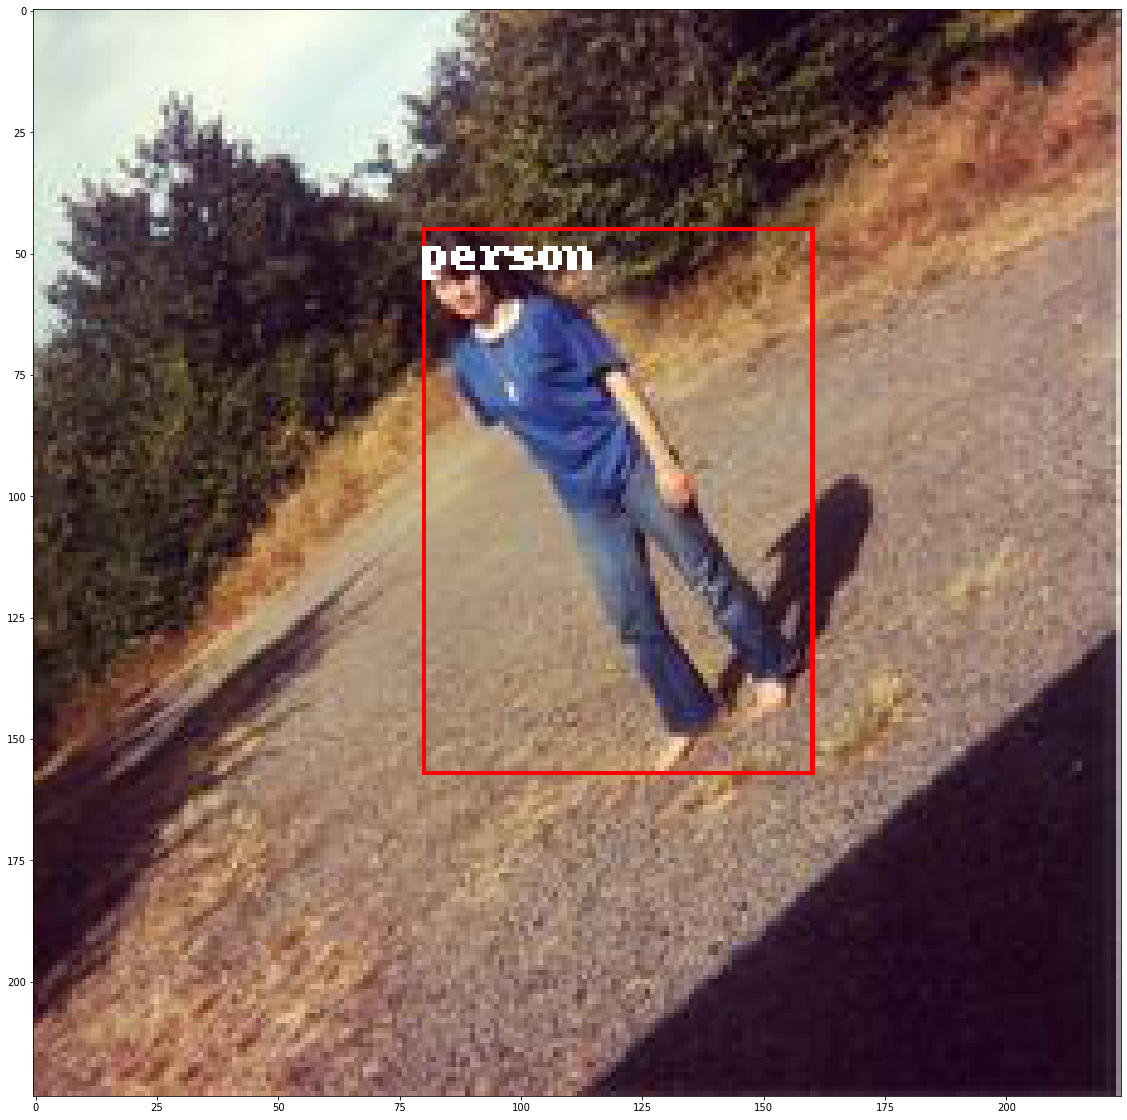

In [9]:
image = Image.open('./JPEGImages_resized\\2007_000027.jpg').convert("RGB")
draw = ImageDraw.Draw(image)

for key, box in _idx2map[0].items():
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red")
    draw.text((box[0], box[1]), key)

plt.figure(figsize=(25,20))
plt.imshow(image)
plt.show()
plt.close()

In [18]:
class customDS(data.Dataset):
    def __init__(self, root, idx2map, idx2files, _class2idx, transform=None):
        self.root = root
        self.idx2map = idx2map
        self._class2idx = _class2idx
        self.idx2files = idx2files
        self.y_data = []
        self.transform = transform
        
        for i in range(len(idx2map)):
            np_label = np.zeros((7, 7, 25), dtype=np.float32)
            
            for key, box in idx2map[i].items():
                xoff = int((box[0]+box[2])/2)
                yoff = int((box[1]+box[3])/2)
                width = box[2] - box[0]
                height = box[3] - box[1]
                
                x_idx = xoff//32
                y_idx = yoff//32
                
                x_ratio = (xoff%32)/32
                y_ratio = (yoff%32)/32
                
                
                class_onehot = np.zeros(20, dtype=np.float32)
                class_onehot[_class2idx[key]] = 1
                
                np_label[x_idx][y_idx] = np.concatenate((np.array([1, x_ratio, y_ratio, width/224, height/224]), class_onehot))
                label = torch.from_numpy(np_label)
            self.y_data.append(label)
                    
    def __getitem__(self, index):
        target = self.y_data[index]
        x_file = self.idx2files[index].split(".")[0]+".jpg"
        
        image = Image.open(os.path.join(self.root, x_file)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
            
        return image, target
        
    def __len__(self):
        return len(self.idx2files)

In [19]:
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

totalDS = customDS("./JPEGImages_resized", _idx2map, idx2file, _class2idx, transform=transform)

In [20]:
print(len(totalDS))

17125


In [21]:
img, target = totalDS.__getitem__(0)
print(img)

tensor([[[ 0.1597, -0.7822, -0.9705,  ...,  1.4098,  1.4440,  1.4269],
         [ 0.6734, -0.2856, -0.6794,  ...,  1.4783,  1.4954,  1.4783],
         [ 0.0056, -0.5253, -0.5253,  ...,  1.5639,  1.5639,  1.5468],
         ...,
         [ 0.3823, -1.4329, -1.3130,  ...,  0.5536,  0.5536,  0.2624],
         [ 0.3823, -1.4158, -1.2617,  ...,  0.3994,  0.4851,  0.2624],
         [ 0.5364, -1.2445, -1.0562,  ...,  0.0569,  0.2967,  0.5364]],

        [[-0.0399, -1.0028, -1.2129,  ...,  1.8158,  1.8508,  1.8333],
         [ 0.4678, -0.5126, -0.9153,  ...,  1.8859,  1.9034,  1.8859],
         [-0.2675, -0.8452, -0.8452,  ...,  1.9734,  1.9734,  1.9559],
         ...,
         [ 0.1527, -1.7031, -1.5805,  ..., -0.2325, -0.2325, -0.5301],
         [ 0.1527, -1.6856, -1.5280,  ..., -0.3901, -0.3025, -0.5301],
         [ 0.3102, -1.5105, -1.3179,  ..., -0.7402, -0.4951, -0.2500]],

        [[ 0.0605, -0.8981, -1.1073,  ...,  1.7685,  1.8034,  1.7860],
         [ 0.5659, -0.4101, -0.8458,  ...,  1

In [22]:
def makeValRandom():
    
    idxList = list(range(len(totalDS)))
    np.random.shuffle(idxList)

    split = int(np.floor(0.7 * len(totalDS)))
    trainIdx, validIdx = idxList[:split], idxList[split:]

    train_sampler = SubsetRandomSampler(trainIdx)
    valid_sampler = SubsetRandomSampler(validIdx)
    
    train_loader = DataLoader(
        dataset=totalDS,
        batch_size=50,
        num_workers=0,
        sampler=train_sampler
    )
    
    val_loader = DataLoader(
        dataset=totalDS,
        batch_size=50,
        num_workers=0,
        sampler=valid_sampler
    )
    
    return train_loader, val_loader

In [23]:
train_loader, val_loader = makeValRandom()

In [24]:
class Obj_Detect(nn.Module):
    def __init__(self):
        super().__init__()
        pretrained = resnet152(pretrained=True)
        layers = list(pretrained.children())[:-1]
        self.resnet = nn.Sequential(*layers)
        
        self.fc1 = nn.Sequential(
            nn.Linear(pretrained.fc.in_features, 4096),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )
        
        self.fc3 = nn.Linear(2048, 7 * 7 * 25)
        
    def forward(self, img):
        with torch.no_grad():
            features = self.resnet(img)
        features = features.view(features.size(0), -1)
        
        out = self.fc1(features)
        out = self.fc2(out)
        out = self.fc3(out)
        
        out = out.reshape((-1, 7, 7, 25))
        out[:, :, :, 0] = torch.sigmoid(out[:, :, :, 0])
        out[:, :, :, 5:] = torch.sigmoid(out[:, :, :, 5:])
        
        return out

In [41]:
def loss_func(predict, target):
    
    batch_size = target.size(0)
    
    hasobj_predict = predict[:, :, :, 0]
    x_predict = predict[:, :, :, 1]
    y_predict = predict[:, :, :, 2]
    w_predict = predict[:, :, :, 3]
    h_predict = predict[:, :, :, 4]
    class_predict = predict[:, :, :, 5:]
    
    hasobj_target = target[:, :, :, 0]
    x_target = target[:, :, :, 1]
    y_target = target[:, :, :, 2]
    w_target = target[:, :, :, 3]
    h_target = target[:, :, :, 4]
    class_target = target[:, :, :, 5:]

    nohasobj_target = torch.neg(torch.add(hasobj_target, -1))
    
    box_loss = 5 * torch.sum(hasobj_target * (torch.pow(x_predict - x_target, 2) + torch.pow(y_predict - y_target, 2)))
    
    size_loss = 5 * torch.sum(hasobj_target * (torch.pow(w_predict - torch.sqrt(w_target), 2) + torch.pow(h_predict - torch.sqrt(h_target), 2)))
    
    hasobj_loss = torch.sum(hasobj_target * torch.pow(hasobj_predict - hasobj_target, 2))
    
    noobj_loss = 0.5 * torch.sum(nohasobj_target * torch.pow(hasobj_predict - hasobj_target, 2))
    
    cls_map = hasobj_target.unsqueeze(-1)

    for i in range(19):
        cls_map = torch.cat((cls_map, hasobj_target.unsqueeze(-1)), 3)
    
    class_loss = torch.sum(cls_map * torch.pow(class_predict - class_target, 2))
    
    
    
    total_loss = box_loss + size_loss + class_loss + noobj_loss + hasobj_loss
    total_loss = total_loss / batch_size
    
    return total_loss, hasobj_loss / batch_size

In [42]:
model = Obj_Detect().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
epochs = 10
total_step = len(train_loader)
valid_step = len(val_loader)

for epoch in range(epochs):
    
    trn_loss = 0
    
    model.train()
    for i, (img, target) in enumerate(train_loader):
        
        img, target = img.to(device), target.to(device)
        
        hypothesis = model(img)
        loss, _ = loss_func(hypothesis, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()
        if((i % 10) == 0):
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, i + 1, total_step, loss.item()))
        
    val_loss = 0
    total_conf_score = 0
    val_batch = 0
    
    model.eval()
    with torch.no_grad():
        
        for i, (img, target) in enumerate(val_loader):
            img, target = img.to(device), target.to(device)
            val_batch += target.size(0)

            results = model(img)
            loss, confidence = loss_func(results, target)

            val_loss += loss.item()
            total_conf_score += confidence.item()
        
        print('    Valid : Epoch [{}/{}], Loss: {:.4f}, avg_confidence_score: {:.2f}'.format(epoch + 1, epochs, val_loss, total_conf_score/val_batch))

Epoch [1/10], Step [1/240], Loss: 24.2938
Epoch [1/10], Step [11/240], Loss: 8.9949


KeyboardInterrupt: 